# A First Crack at Value Function Iteration

(Inspired from [here](https://www3.nd.edu/~esims1/val_fun_iter.pdf))

Here's a simple Python script I wrote for finding the solution to a deterministic, infinite-horizon consumption problem. Please keep in mind that this script is optimized for intuition and understanding, rather than performance, so this might take some time to run.

The sequence problem is defined as $$\sum_{t=0}^{\infty} \beta^tu(c_t)$$ such that $$c_t + k_{t+1} \leq k^\alpha + (1-\delta)k$$

The utility function is given by $$u(c) = \frac{c^{1-\sigma} - 1}{1 - \sigma}$$

## Bellman Equation

Rewrite the above as a recursive problem:

$$ V(k) = \max_c \{u(c) + \beta V(k_{+1})\} $$

I will assume that the constraint binds and that the choice variable is $k_{+1}$. This gives me

$$ V(k) = \max_{k_{+1}} \left\{\frac{[k^\alpha + (1-\delta)k - k_{+1}]^{1-\sigma} - 1}{1- \sigma} + \beta V(k_{+1})\right\} $$

The objective of this exercise is to get the value function $V(k)$ and the policy function $K_{+1}(k)$. Since this is a numerical analysis, we will be solving for the shape of these functions (as opposed to functional forms). To plot the shape of these functions, we first need a domain a.k.a "state space". For each value of $k$ in this state space, we will be solving for what the maximum function $V$ and the choice function $K_{+1}$ look like.

## The State Space

While $V(k)$ and the policy function are continuous functions, we will need to specify a discrete domain (you can't plot an uncountable set). The general strategy seems to be to take 100 to 300 points, spaced evenly around the steady state value of $k = k^*$. Let's quickly solve for this steady state. 


From the Euler equation, $c^{-\sigma} = \beta c^{-\sigma}_{+1}(\alpha k^{\alpha - 1}_{+1} + (1-\delta))$. Setting $c= c_{+1} = c^*$, we get 

$$ \left[\frac{1}{\beta} - (1 - \delta) \right]^{-1} = \frac{1}{\alpha}(k^*)^{1-\alpha}$$

OR 

$$k^* = \left[\alpha\left[\frac{1}{\beta} - (1 - \delta) \right]^{-1}\right]^{1/(1-\alpha)}$$

Let's calculate this in Python.



In [4]:
# Loading packages I will be using
from __future__ import division
import numpy as np
from scipy.optimize import fminbound
import matplotlib.pyplot as plt

# Initializing Parameters
alpha   = 0.333
beta    = 0.984
delta   = 0.025
sigma   = 2

# Steady State Capitak Stock
k_star  = (alpha*((1/beta) - (1 - delta))**(-1))**(1/(1-alpha))
print "K_star = ", k_star 

K_star =  22.8923355199


Now, we can create our state space. To make this run fast, let's only consider a space with 100 points centered around the steady state capital stock value.

In [9]:
points = 99
Kmin, Kmax = k_star*0.25, k_star*1.75
step_size = (Kmax - Kmin)/points
state_space = np.arange(Kmin, Kmax+step_size, step_size) # Kmax ia aet to Kmax + step_size to make sure it is in the state space
print "Number of points in the state space = ", len(state_space)

Number of points in the state space =  100


## The General Strategy
Keeping in mind how a Bellman operator behaves, we just need to construct a function that starts off with a stupid guess for the value function $V$, and iterates enough times until we get close enough to the actual value function implied by the problem (note that this is guaranteed by Contraction Mapping Theorem). 

In each iteration, the value function will look like

$$ V^n(k) = \max_{k_{+1}} \left\{\frac{[k^\alpha + (1-\delta)k - k_{+1}]^{1-\sigma} - 1}{1- \sigma} + \beta V^{n-1}(k_{+1})\right\}$$

I am going to call this equation ($\ast$). 

Let's initialize our "stupid" guess for the value function. I will also initialize two other vectors - one for the final value function, and the other for the policy function. 

In [15]:
# Initial guess of all zeroes
V_0 = np.zeros(len(state_space)) 

# Initializing another vector to keep track of updated value function (post iteration)
V_1 = np.zeros(len(state_space)) 

# Poilcy Function
K_1 = np.zeros(len(state_space))

## Defining the Value Function

We will use the form of equation $(\ast)$ above to update the value function after each iteration. Within each iteration, I will use scipy's **fminbound** function to find the value of $k_{+1}$ that maximizes the value function. Once I have this $k_{+1}$, which is the argmax of equation $(\ast)$, I will calculate $V^n(k)$ and save it for the next iteration. But there is one small problem...

### Problem with a Discrete Space
To calculate $V^n(k)$, I need $V^{n-1}(k_{+1})$. But, we don't know the functional form of $V^{n-1}(\cdot)$, and we only have values of $V^{n-1}(\cdot)$ for a finite set of $k$'s. So, we will not be able to proceed if scipy's **fminbound** throws out an argmax $k_{+1}$, for which we don't have $V^{n-1}(k_{+1})$. This is where we use **linear interpolation**.

### Linear Interpolation
Suppose we have a $k_{+1}$ which is not in our grid, and therefore, we don't have a value $V^{n-1}(k_{+1})$ saved in our vector of values for $V^{n-1}$. To get this $V^{n-1}(k_{+1})$, we will estimate the equation of a line around $k_{+1}$ using values of $V^{n-1}$ for $k$ which are actually in our grid. 

The formula for this interpolation is given by:

$$ V(k_{+1}) \approx V(k(i)) + \frac{V(k(i+1)) - V(k(i))}{k(i + 1) - k(i)}(k_{+1} - k(i))$$

where $i$ and $(i+1)$ are the indices for values of capital directly above and below $k_{+1}$ that are also in our discrete state space.

### Non-negative Consumption
An implicit constraint on consumption is that it must not be negative. I will also incorporate this constraint into my code for the value function (basically, we will introduce a penalty on the maximizer **fminbound** if consumption dips below zero in any iteration).


Finally, note that **fminbound** is designed to find the minimum. We can still use it to find a max if we multiply its argument by -1.

In [ ]:
# Defining the value function (which goes in as the argument to fminbound)
def V(k1, k0):
    # First, we need to interpolate the value of 
    below = (state_space < k1).sum() - 1 # Getting index of capital value directly below k
    above = below + 1                     # Index for capital value directly above k

    # Interpolation/Estimating V{n-1}(k) where k is the argmax from fminbound
    V_minus_1 = V_0[below] + (k1 - state_space[below])*((V_0[above] - V_0[below])/(state_space[above] - state_space[below]))
    
    # Defining Consumption
    C = k0**alpha + (1-delta)*k0 - k1
    
    # Introducing a heavy penalty on the value function if consumption is below zero
    if C < 0:
        value = -999999 - 999*np.abs(C)
    else:
        value = (1/(1-sigma))*(C**(1 - sigma) - 1) + beta*V_minus_1 # This is the value function
        
    # Output negative of value function since fminbound is minimizing    
    return -1*value

## The Contraction Loop

I will run 300 iterations. In each iteration, I will loop over the vector "state space". For each value of state space $k$, I will use **fminbound** to find the maximizing value $k_{+1}$. Once I have this $k_{+1}$, I will plug it into the value function, along with $k$ to get $V^n(k)$, and save this in my vector V1 as defined above. I will also save the value $k_{+1}$ in my vector containing the policy function. 

Finally, once I am done looping over all values of the state space, I will update the V0 vector using V1 vector to use it in the next iteration. 

In [ ]:
# Initializing Iteration Count
iters = 0
while iters < 300:
    for i in xrange(len(state_space)):
        k0 = state_space[i]
        k1 = float(fminbound(V, Kmin, Kmax, args=(k0,))) # Using Kmin and Kmax to define the bounds over which to optimize
        V_1[i] = -1*V(k1, k0)
        K_1[i] = k1
    V_0 = V_1
    iters += 1

# AND WE ARE DONE!

Let's run the entire thing at once, and also plot the value and policy functions.

# FULL SCRIPT

K_star =  22.8923355199
Number of points in the state space =  100


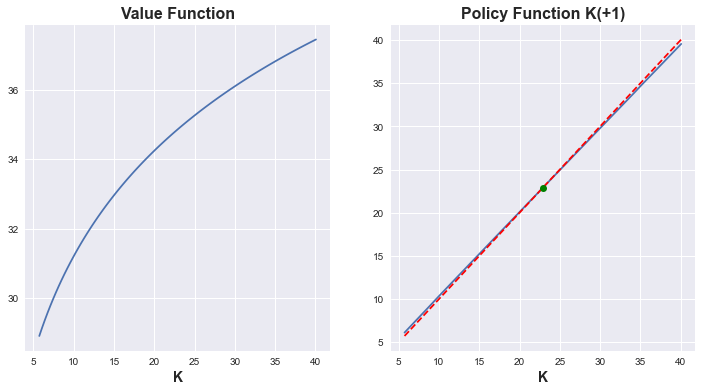

In [3]:
# Loading packages I will be using
from __future__ import division
import numpy as np
from scipy.optimize import fminbound
import matplotlib.pyplot as plt

# Initializing Parameters
alpha   = 0.333
beta    = 0.984
delta   = 0.025
sigma   = 2

# Steady State Capitak Stock
k_star  = (alpha*((1/beta) - (1 - delta))**(-1))**(1/(1-alpha))
print "K_star = ", k_star 

points = 99
Kmin, Kmax = k_star*0.25, k_star*1.75
step_size = (Kmax - Kmin)/points
state_space = np.arange(Kmin, Kmax+step_size, step_size)
print "Number of points in the state space = ", len(state_space)


# Defining the value function (which goes in as the argument to fminbound)
def V(k1, k0):
    # First, we need to interpolate the value of 
    below = (state_space < k1).sum() - 1 # Getting index of capital value directly below k
    above = below + 1                     # Index for capital value directly above k

    # Interpolation/Estimating V{n-1}(k) where k is the argmax from fminbound
    V_minus_1 = V_0[below] + (k1 - state_space[below])*((V_0[above] - V_0[below])/(state_space[above] - state_space[below]))
    
    # Defining Consumption
    C = k0**alpha + (1-delta)*k0 - k1
    
    # Introducing a heavy penalty on the value function if consumption is below zero
    if C < 0:
        value = -999999 - 999*np.abs(C)
    else:
        value = (1/(1-sigma))*(C**(1 - sigma) - 1) + beta*V_minus_1 # This is the value function
        
    # Output negative of value function since fminbound is minimizing    
    return -1*value

# Initializing Iteration Count
iters = 0
# Initial guess of all zeroes
V_0 = np.zeros(len(state_space))
# Initializing another vector to keep track of updated value function (post iteration)
V_1 = np.zeros(len(state_space)) 
# Poilcy Function
K_1 = np.zeros(len(state_space))

while iters < 300:
    for i in xrange(len(state_space)):
        k0 = state_space[i]
        k1 = float(fminbound(V, Kmin, Kmax, args=(k0,))) # Using Kmin and Kmax to define the bounds over which to optimize
        V_1[i] = -1*V(k1, k0)
        K_1[i] = k1
    V_0 = V_1
    iters += 1
    
# Plotting
import seaborn as sns
%matplotlib inline
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(state_space, V_1)
ax1.set_title("Value Function", fontsize = 16, weight = 'bold')
ax1.set_xlabel('K', weight = 'bold', size = 14)

ax2 = fig.add_subplot(122)
ax2.plot(state_space, K_1)
ax2.plot(state_space, state_space, 'r--')
ax2.plot(k_star, k_star, 'go')
ax2.set_title("Policy Function K(+1)", fontsize = 16, weight = 'bold')
ax2.set_xlabel('K', weight = 'bold', size =14)
plt.show()

The value function is very smooth, thanks to the small size of our state space and linear interpolation. The policy function is almost the 45-degree line (as shown in red) -- the policy function intersects the 45-degree line at the steady state value $k^*$ calculated above. 